In [1]:
!git clone https://github.com/belfassikhaoula123/Projet_RGD.git

Cloning into 'Projet_RGD'...
remote: Enumerating objects: 5544, done.
remote: Counting objects: 100% (5544/5544), done.
remote: Compressing objects: 100% (5518/5518), done.
remote: Total 5544 (delta 41), reused 5470 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (5544/5544), 4.65 MiB | 10.17 MiB/s, done.
Resolving deltas: 100% (41/41), done.
Updating files: 100% (7867/7867), done.
Filtering content: 100% (7859/7859), 1007.38 MiB | 3.65 MiB/s, done.


In [2]:
import pandas as pd
import glob
import os
import random
import numpy as np
import cv2


In [3]:
df=pd.read_csv("/content/Projet_RGD/Data/data.csv")
df.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

In [6]:
data_map = []

for sub_dir_path in glob.glob("/content/Projet_RGD/Data/kaggle_3m/*"):
    try:
        dir_name = os.path.basename(sub_dir_path)
        for filename in os.listdir(sub_dir_path):
            image_path = os.path.join(sub_dir_path, filename)
            data_map.append([dir_name, image_path])
    except Exception as e:
        print(e)

In [7]:
df1 = pd.DataFrame(data_map, columns=["patient_id", "image_path"])
df1.head()

,patient_id,image_path
0,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...
1,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...
2,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...
3,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...
4,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...


In [8]:
df_imgs = df1[~df1['image_path'].str.contains("mask")]
df_masks = df1[df1['image_path'].str.contains("mask")]

# extraction dfu numéro de l'image
BASE_LEN = 79 # index ou commence le numéro
END_IMG_LEN = 4 # nombre de chaines de caractères à éliminer de la fin du chemin de l'image
END_MASK_LEN = 9 # nombre de chaines de caractères à éliminer de la fin du chemin du mask

# trier les images et masks selon leur numéros
imgs = sorted(df_imgs["image_path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["image_path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

#vérification
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: /content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_15.tif 
Path to the Mask: /content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_15_mask.tif


# Creation de la data finale

In [9]:
df_final = pd.DataFrame({
    "patient_id": df_imgs.patient_id.values,
    "image_path": imgs,
    "mask_path": masks
})

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

In [10]:
df_final['mask'] = df_final['mask_path'].apply(lambda x: pos_neg_diagnosis(x))

In [11]:
df_final

,patient_id,image_path,mask_path,mask
0,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_A5T...,0
1,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_FG_764...,/content/Projet_RGD/Data/kaggle_3m/TCGA_FG_764...,0
2,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_585...,/content/Projet_RGD/Data/kaggle_3m/TCGA_DU_585...,0
3,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_CS_494...,/content/Projet_RGD/Data/kaggle_3m/TCGA_CS_494...,0
4,TCGA_DU_A5TR_19970726,/content/Projet_RGD/Data/kaggle_3m/TCGA_CS_539...,/content/Projet_RGD/Data/kaggle_3m/TCGA_CS_539...,0
...,...,...,...,...
3924,TCGA_FG_6690_20020226,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,0
3925,TCGA_FG_6690_20020226,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,0
3926,TCGA_FG_6690_20020226,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,0
3927,TCGA_FG_6690_20020226,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,/content/Projet_RGD/Data/kaggle_3m/TCGA_HT_A61...,0


In [12]:
df_final["mask"].value_counts()

,count
mask,
0,2556
1,1373


## Pondération des classes

In [13]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_final['mask']),
    y=df_final['mask']
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
class_weights

{0: np.float64(0.7685837245696401), 1: np.float64(1.4308084486525856)}

## Data Visualisation

In [55]:
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x=df_final['mask'].value_counts().index,
                        y=df_final['mask'].value_counts(),
                        width=[.4, .4]
                       )
                ])
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4, opacity=0.4
                 )
fig.update_layout(title_text="Graphique du nombre des masks",
                  width=700,
                  height=550,
                  yaxis=dict(
                             title_text="Count",
                             tickmode="array",
                             titlefont=dict(size=20)
                           )
                 )
fig.update_yaxes(automargin=True)
fig.show()


In [ ]:
import matplotlib.pyplot as plt


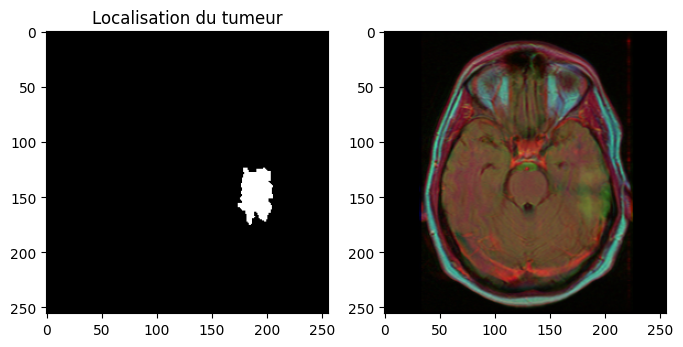

In [ ]:
for i in range(len(df_final)):
    if cv2.imread(df_final.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(df_final.mask_path[i]));
plt.title('Localisation du tumeur')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(df_final.image_path[i]));

In [ ]:
cv2.imread(df_final.mask_path[i]).max(), cv2.imread(df_final.mask_path[i]).min()

(255, 0)

Les valeurs min=0 et max=255 indiquent que le masque est binaire et contient bien une région annotée. La présence de la valeur 255 confirme l’existence d’une zone tumorale sur cette image.

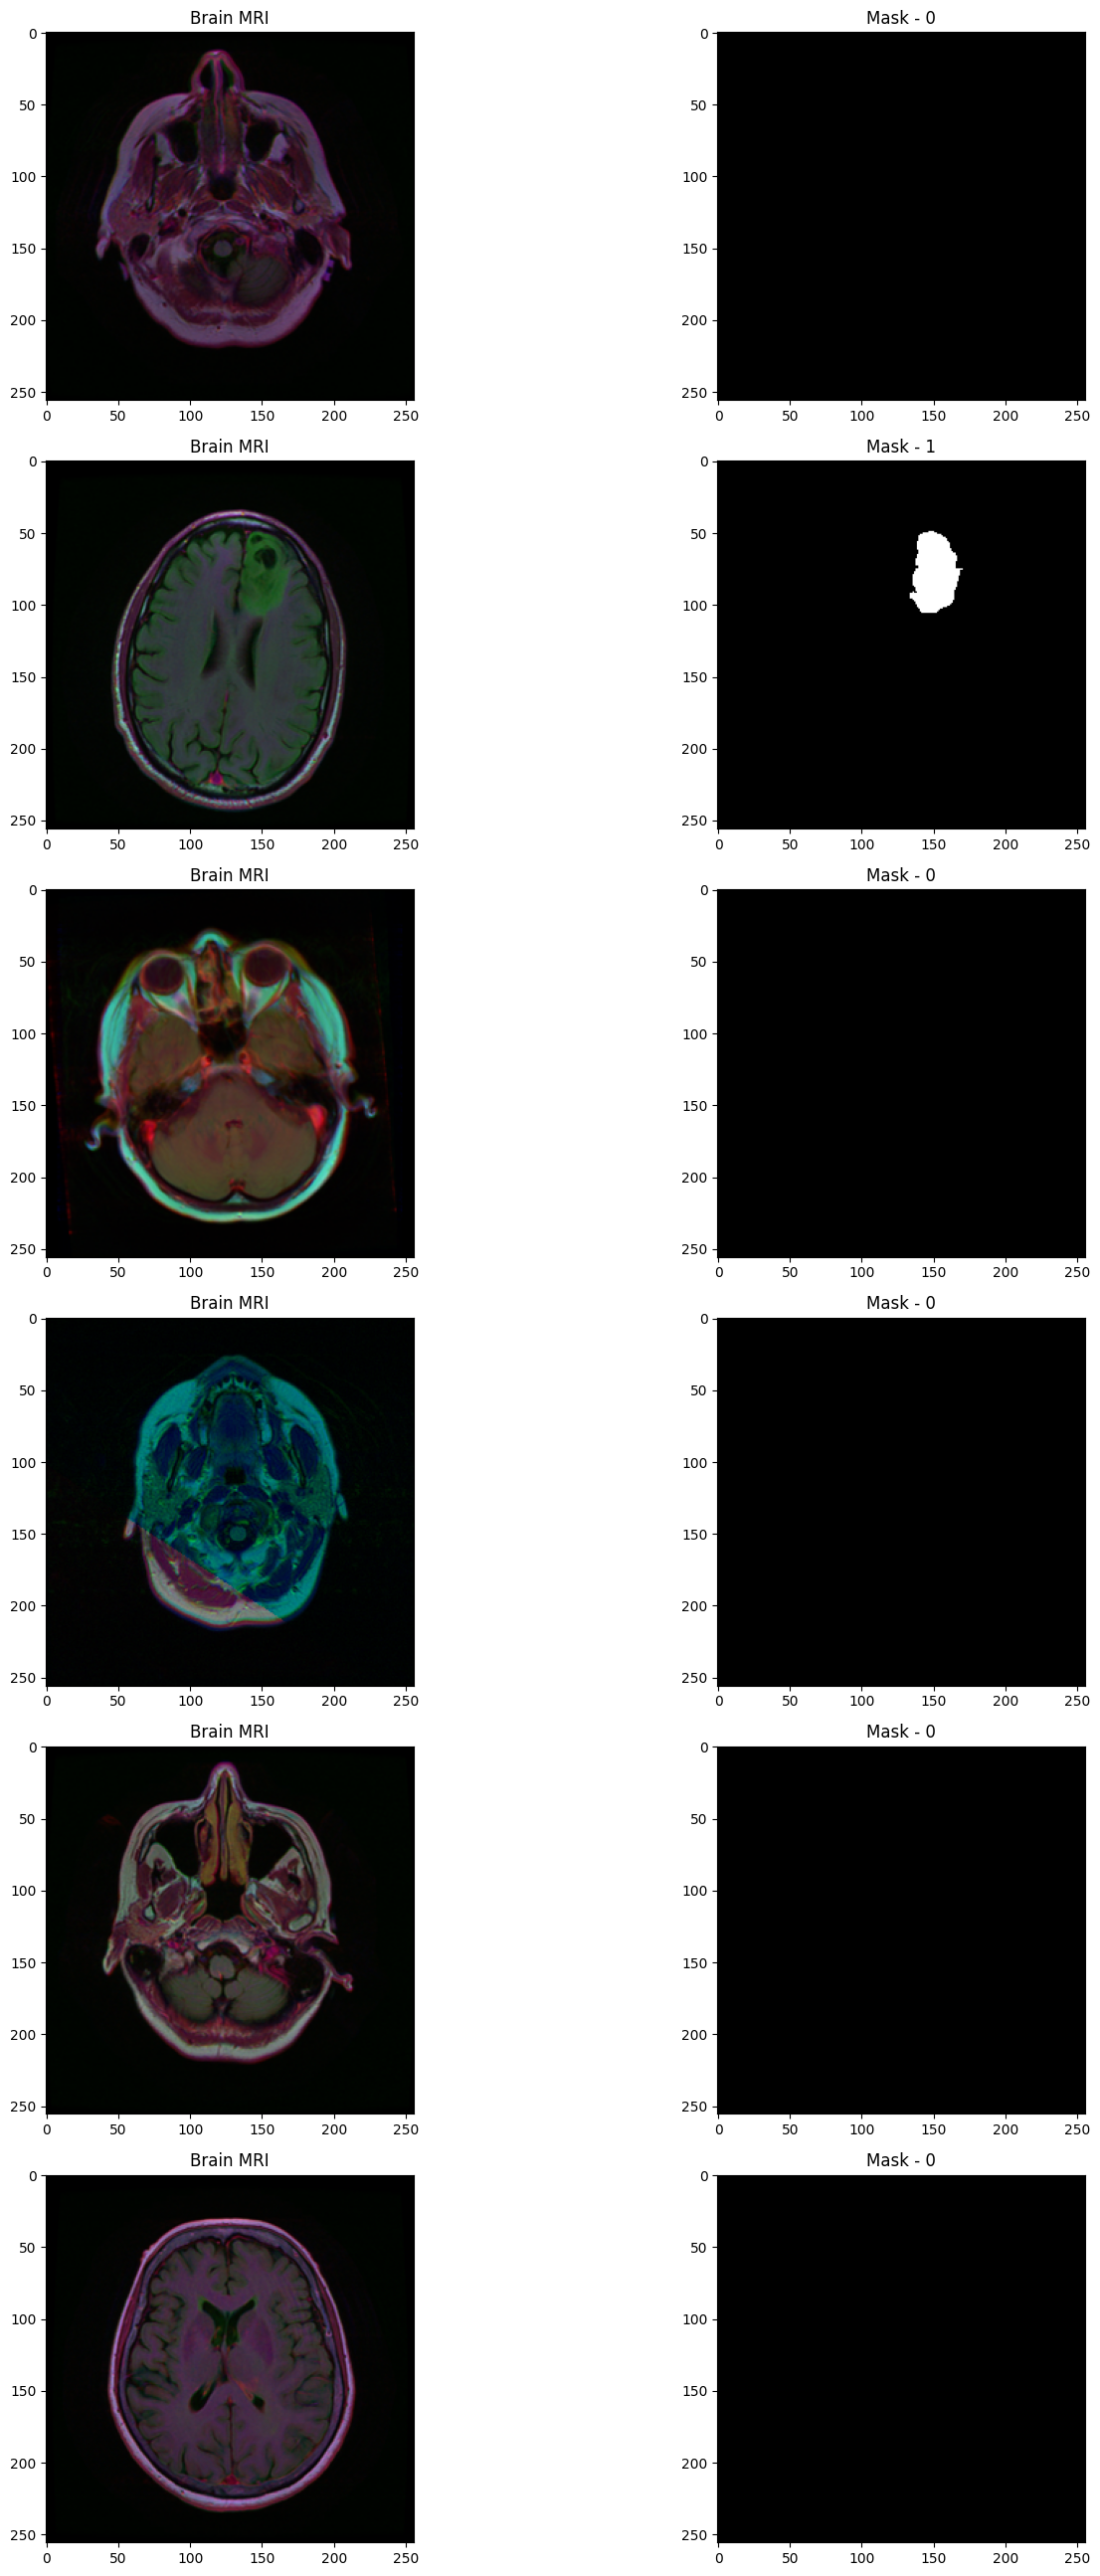

In [ ]:
# Visualisations de base : afficher séparément les images (IRM et masques) du dataset
fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(df_final))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(df_final.image_path[i]))
  axs[count][1].title.set_text("Mask - " + str(df_final['mask'][i]))
  axs[count][1].imshow(cv2.imread(df_final.mask_path[i]))
  count += 1

fig.tight_layout()

# Affichage des images cérébrales (IRM) et superposition des masques de tumeur

In [ ]:
import cv2

img = cv2.imread(df_final.image_path[i])
mask = cv2.imread(df_final.mask_path[i], cv2.IMREAD_GRAYSCALE)  # masque en niveau de gris


In [ ]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


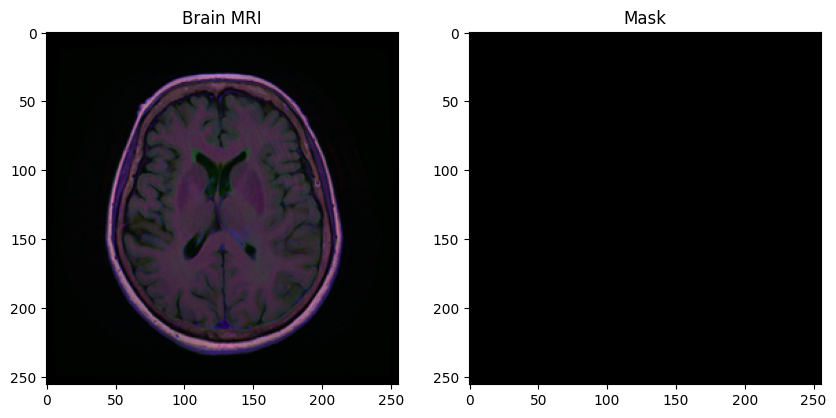

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Brain MRI")

plt.subplot(1,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

plt.show()


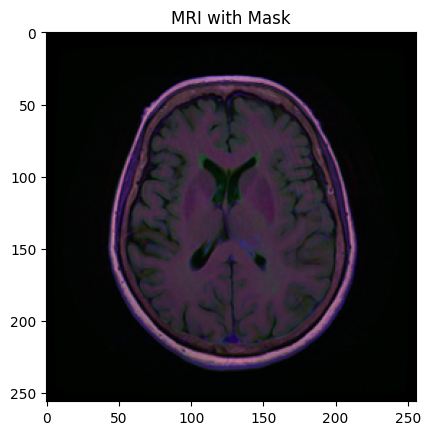

In [ ]:
img_overlay = img_rgb.copy()

img_overlay[mask==255] = (0,255,150)

plt.imshow(img_overlay)
plt.title("MRI with Mask")
plt.show()


# Split des données

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import *

In [15]:
df_final = df_final.drop(columns=['patient_id'])
df_final['mask'] = df_final['mask'].apply(lambda x: str(x))

In [16]:
df_train, df_test = train_test_split(df_final, test_size = 0.1, random_state = 42)
df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 42)
print('train data shape: ', df_train.values.shape)
print('val data shape:   ', df_val.values.shape)
print('test data shape:  ', df_test.values.shape)

train data shape:  (3182, 3)
val data shape:    (354, 3)
test data shape:   (393, 3)


# Augmentation des données

In [17]:
# Data augmentation pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Pas d'augmentation pour validation et test, juste normalisation
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Générateur d'entraînement
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='mask',
    target_size=(256,256),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

# Générateur de validation
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='mask',
    target_size=(256,256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

# Générateur de test
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='mask',
    target_size=(256,256),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)


Found 3182 validated image filenames belonging to 2 classes.
Found 354 validated image filenames belonging to 2 classes.
Found 393 validated image filenames belonging to 2 classes.


# Modèle CNN pour la classification des tumeurs

## Initialisation du modéle

In [18]:
from tensorflow.keras import layers, models
# CNN pour classification binaire d'images 256x256x3 : 3 blocs Conv2D
# + MaxPooling pour extraire des caractéristiques
# + Flatten pour vectoriser
# + Dense(128) pour combiner les features
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,105 (56.61 MB)

 Trainable params: 14,839,105 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

## Entrainement du modèle

In [19]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 66s 290ms/step - accuracy: 0.6519 - loss: 0.6320 - val_accuracy: 0.7712 - val_loss: 0.4246
Epoch 2/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 53s 266ms/step - accuracy: 0.7248 - loss: 0.5365 - val_accuracy: 0.8192 - val_loss: 0.4087
Epoch 3/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.7387 - loss: 0.4973 - val_accuracy: 0.7910 - val_loss: 0.4061
Epoch 4/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 251ms/step - accuracy: 0.7459 - loss: 0.4735 - val_accuracy: 0.7966 - val_loss: 0.4295
Epoch 5/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - accuracy: 0.7475 - loss: 0.4617 - val_accuracy: 0.7994 - val_loss: 0.4257
Epoch 6/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.7445 - loss: 0.4621 - val_accuracy: 0.7994 - val_loss: 0.3970
Epoch 7/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 50s 250ms/step - accuracy: 0.7497 - loss: 0.4636 - val_accuracy: 0.7966 - val_loss: 0.3710
Epoch 8/20
199/199 ━━━━━━━━━━━━━━━━━━━━ 49s 248ms/step - accuracy: 0.7516 - loss: 0

## Evaluation des performances du modèle

In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8903 - loss: 0.2589
Test Accuracy: 0.9007633328437805
Test Loss: 0.25413408875465393


In [21]:
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_generator.labels

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [22]:
y_true = test_generator.labels

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("AUC:", roc_auc_score(y_true, y_pred_prob))

# Matrice de confusion
report = classification_report(y_true, y_pred)
print("Classification Report:\n", report)


Accuracy: 0.9007633587786259
Precision: 0.8026315789473685
Recall: 0.9312977099236641
F1 Score: 0.8621908127208481
AUC: 0.9658236699493037
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92       262
           1       0.80      0.93      0.86       131

    accuracy                           0.90       393
   macro avg       0.88      0.91      0.89       393
weighted avg       0.91      0.90      0.90       393



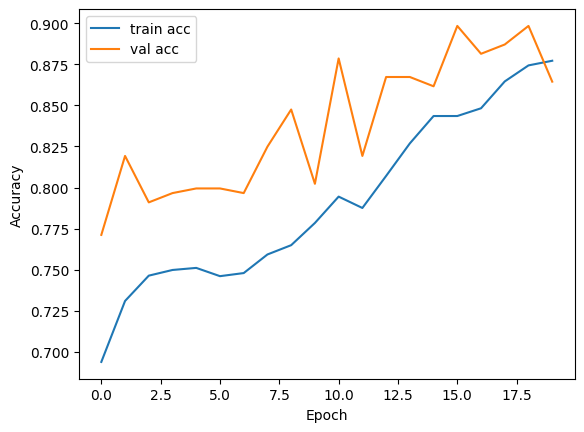

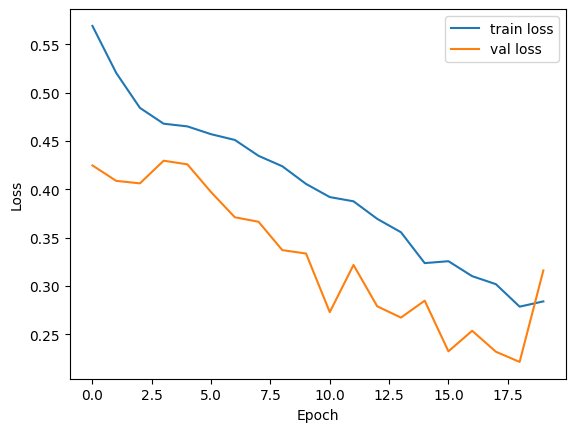

In [24]:
import matplotlib.pyplot as plt

# Tracé de l'évolution de l'accuracy pendant l'entraînement
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Tracé de l'évolution de la loss pendant l'entraînement
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


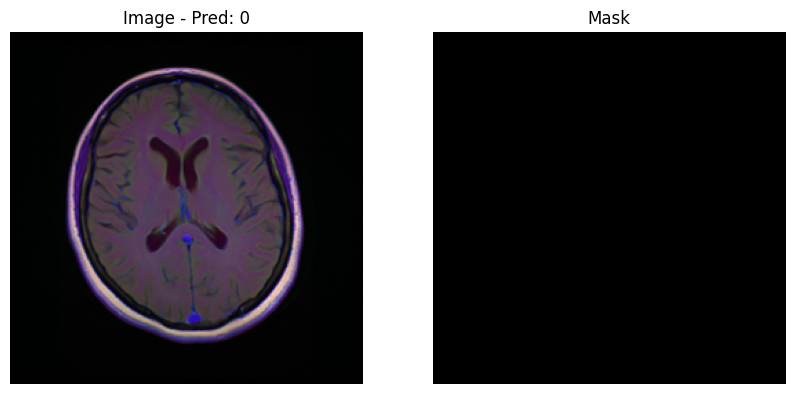

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


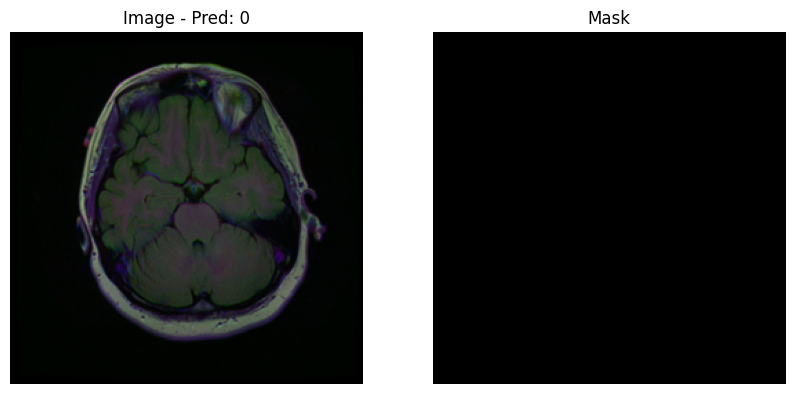

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


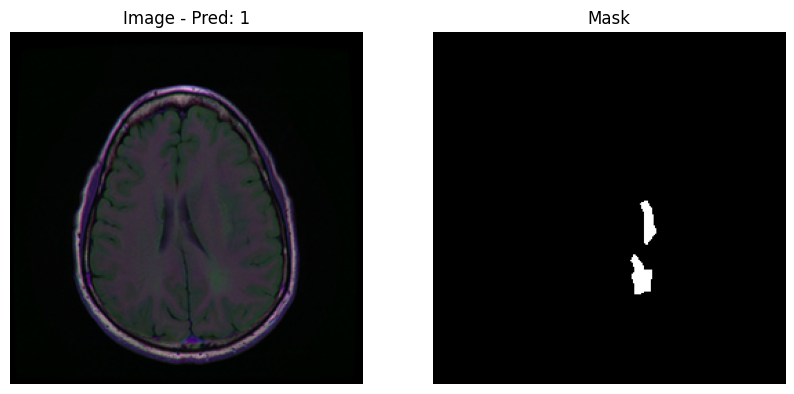

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

# Sélectionner 3 indices aléatoires dans df_val
random_indices = random.sample(range(len(df_val)), 3)

for idx in random_indices:
    # Chemin de l'image et du mask
    img_path = df_val.iloc[idx]['image_path']
    mask_path = df_val.iloc[idx]['mask_path']

    # Charger l'image et le mask
    img = image.load_img(img_path, target_size=(256, 256))
    img_array = image.img_to_array(img) / 255.0

    mask = image.load_img(mask_path, color_mode="grayscale", target_size=(256, 256))
    mask_array = np.array(mask) / 255.0

    # Ajouter dimension batch pour prédiction
    img_array_batch = np.expand_dims(img_array, axis=0)

    # Prédiction du modèle
    pred = model.predict(img_array_batch)
    pred_class = int(pred[0][0] > 0.5)

    # Affichage
    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].imshow(img)
    axs[0].set_title(f"Image - Pred: {pred_class}")
    axs[0].axis('off')

    axs[1].imshow(mask_array, cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis('off')

    plt.show()
